In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import langevin
from scipy.stats import pearsonr,gaussian_kde, chi2
from scipy.optimize import root

SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

#SEED = 35010732 # from random.org
#np.random.seed(SEED)

print(plt.style.available)
plt.style.use('seaborn-white')

['Solarize_Light2', '_classic_test_patch', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']


In [3]:
def correlated_ts(c,delta_t = 0.1,N=1000):
    # parameters for coupled oscillator
    K,D = 1.0,1.0
    data1 = langevin.time_series(A=1/K, D=D, delta_t=delta_t, N=N)
    data2 = langevin.time_series(A=1/(K+np.abs(c)), D=D, delta_t=delta_t, N=N)
    x1 = (data1 + data2)/2
    if c>0:
        x2 = (data1 - data2)/2
    else:
        x2 = (data2-data1)/2

    return x1,x2

def c_rho(rho):
    return 2*np.abs(rho)/(1-np.abs(rho))*np.sign(rho)


In [4]:
def calc_fundstats(x):
    return x[0]**2+x[-1]**2,np.sum(x[1:-1]**2),np.sum(x[0:-1]*x[1:])

In [5]:
def b(D,A,delta_t):
    return np.exp(-D/A*delta_t)

def q(aep,ass,ac,b):
    return (aep + (1+b**2)*ass - 2*b*ac)/(1-b**2)

def dqdB(aep,ass,ac,b):
    return 2*(b*aep+2*b*ass-(1+b**2)*ac)/(1-b**2)**2

def d2qdB2(aep,ass,ac,b):
    return (6*b+2)/(1-b**2)**3*(aep+2*ass)-(4*b**3+12*b)/(1-b**2)**3*ac

def dBdA(b,D,A,delta_t):
    return b*D*delta_t/A**2

def dBdD(b,A,delta_t):
    return -b*delta_t/A

def d2BdA2(b,D,A,delta_t):
    return b*D*delta_t/A**3*(D*delta_t/A-2)

def d2BdD2(b,A,delta_t):
    return b*delta_t**2/A**2

def d2BdAdD(b,D,A,delta_t):
    return b*delta_t/A**2*(1-D*delta_t/A)

def d2qdD2(aep,ass,ac,b,A,delta_t):
    return d2qdB2(aep,ass,ac,b)*dBdD(b,A,delta_t)**2+dqdB(aep,ass,ac,b)*d2BdD2(b,A,delta_t)

def d2qdA2(aep,ass,ac,b,D,A,delta_t):
    return d2qdB2(aep,ass,ac,b)*dBdA(b,D,A,delta_t)**2+dqdB(aep,ass,ac,b)*d2BdA2(b,D,A,delta_t)

def d2qdAdD(aep,ass,ac,b,D,A,delta_t):
    return d2qdB2(aep,ass,ac,b)*dBdA(b,D,A,delta_t)*dBdD(b,A,delta_t)+dqdB(aep,ass,ac,b)*d2BdAdD(b,D,A,delta_t)

#def d2PdA2(N,aep,ass,ac,b,D,A,delta_t):
#    return (N/2/A**2 - 
#            q(aep,ass,ac,b)/A**3 +
#            (N-1)/(1-b**2)*(b*d2BdA2(b,D,A,delta_t) + dBdA(b,D,A,delta_t)**2*(1+b**2)/(1-b**2)) -
#            d2qdA2(aep,ass,ac,b,D,A,delta_t)/2/A +
#           1/A**2*dqdB(aep,ass,ac,b)*dBdA(b,D,A,delta_t))

def d2PdA2(N,aep,ass,ac,b,D,A,delta_t):
    return (-N/2/A**2 + 
            (N-1)/(1-b**2)*(b*d2BdA2(b,D,A,delta_t) + 
                            dBdA(b,D,A,delta_t)**2*(1+b**2)/(1-b**2) +
                           2*b/A*dBdA(b,D,A,delta_t)) -
            d2qdA2(aep,ass,ac,b,D,A,delta_t)/2/A)
        
def d2PdAdD(N,aep,ass,ac,b,D,A,delta_t):
    return (dqdB(aep,ass,ac,b)*dBdD(b,A,delta_t)/2/A**2 -
            d2qdAdD(aep,ass,ac,b,D,A,delta_t)/2/A +
            (N-1)/(1-b**2)*(b*d2BdAdD(b,D,A,delta_t) + dBdA(b,D,A,delta_t)*dBdD(b,A,delta_t)*(1+b**2)/(1-b**2)))

def d2PdD2(N,a1ep,a1ss,a1c,a2ep,a2ss,a2c,b1,b2,D,A1,A2,delta_t):
    return ((N-1)/(1-b1**2)*(b1*d2BdD2(b1,A1,delta_t) + dBdD(b1,A1,delta_t)**2*(1+b1**2)/(1-b1**2))+
           (N-1)/(1-b2**2)*(b2*d2BdD2(b2,A2,delta_t) + dBdD(b2,A2,delta_t)**2*(1+b2**2)/(1-b2**2))-
           d2qdD2(a1ep,a1ss,a1c,b1,A1,delta_t)/2/A1 -
           d2qdD2(a2ep,a2ss,a2c,b2,A2,delta_t)/2/A2)
           
def phi_deriv(x,a1ep,a1ss,a1c,a2ep,a2ss,a2c,delta_t,N):
    # x[0] = A1, x[1] = A2, x[2]=D
    A1 = x[0]
    A2 = x[1]
    D = x[2]
    b1 = b(D,A1,delta_t)
    b2 = b(D,A2,delta_t)
    Q1 = q(a1ep,a1ss,a1c,b1)
    Q2 = q(a2ep,a2ss,a2c,b2)
    dQ1 = dqdB(a1ep,a1ss,a1c,b1)
    dQ2 = dqdB(a2ep,a2ss,a2c,b2)
    y1 = -N*A1**2/2 + A1*Q1/2 + b1*D*delta_t*(A1*b1*(N-1)/(1-b1**2)-dQ1/2)
    y2 = -N*A2**2/2 + A2*Q2/2 + b2*D*delta_t*(A2*b2*(N-1)/(1-b2**2)-dQ2/2)
    y3 = (b1*(N-1)/(1-b1**2)-dQ1/A1/2)*b1/A1 + (b2*(N-1)/(1-b2**2)-dQ2/A2/2)*b2/A2
    return np.array([y1,y2,y3])

def hessian(x,a1ep,a1ss,a1c,a2ep,a2ss,a2c,delta_t,N):
    # x[0] = A1, x[1] = A2, x[2]=D
    A1 = x[0]
    A2 = x[1]
    D = x[2]
    b1 = b(D,A1,delta_t)
    b2 = b(D,A2,delta_t)
    d2PdA2_1m = d2PdA2(N,a1ep,a1ss,a1c,b1,D,A1,delta_t)
    d2PdA2_2m = d2PdA2(N,a2ep,a2ss,a2c,b2,D,A2,delta_t)
    d2PdD2m = d2PdD2(N,a1ep,a1ss,a1c,a2ep,a2ss,a2c,b1,b2,D,A1,A2,delta_t)
    d2PdAdD_1m = d2PdAdD(N,a1ep,a1ss,a1c,b1,D,A1,delta_t)
    d2PdAdD_2m = d2PdAdD(N,a2ep,a2ss,a2c,b2,D,A2,delta_t)
    return np.array([[d2PdA2_1m,0,d2PdAdD_1m],[0,d2PdA2_2m,d2PdAdD_2m],[d2PdAdD_1m,d2PdAdD_2m,d2PdD2m]])

In [6]:
def d2PdA2N(N,b,A,delta_t):
    return -N/2/A - N/(1-b**2)**2*dBdA(b,D,A,delta_t)**2*(1+b**2+6*b/(1+b))+2*N*b/(1-b**2)*dBdA(b,D,A,delta_t)

def d2PdAdDN(N,b,D,A,delta_t):
    return N*b/(1-b**2)*dBdD(b,A,delta_t) - N/(1-b**2)**2*dBdA(b,D,A,delta_t)*dBdD(b,A,delta_t)*(1+b**2+6*b/(1+b))

def d2PdD2N(N,b1,b2,D,A1,A2,delta_t):
    return (-N/(1-b1**2)**2*dBdD(b1,A1,delta_t)**2*(1+b1**2+6*b1/(1+b1))-
            N/(1-b2**2)**2*dBdD(b2,A2,delta_t)**2*(1+b2**2+6*b2/(1+b2)))

In [7]:
corr1k = pd.read_csv("correlations1k09_PYMC.csv")
corr1k

,rho,coupling,pearson,C,dC,a1,da1,a2,da2,d,...,da1dd,dasdd,a1ep,a1ss,a1c,a2ep,a2ss,a2c,c,dc
0,0.9,18.0,0.897287,18.055543,1.849150,1.013134,0.087223,0.053275,0.002410,1.015557,...,0.000145,2.551072e-07,1.246679,991.241861,731.117751,0.131733,52.979265,-1.052314,18.055543,1.849150
1,0.9,18.0,0.886394,15.877805,1.597496,0.981562,0.081639,0.058277,0.002666,1.050923,...,0.000178,-1.409790e-06,1.963859,960.369212,693.123713,0.073004,57.833890,3.224018,15.877805,1.597496
2,0.9,18.0,0.900755,19.288858,1.994403,1.062511,0.092750,0.052478,0.002410,1.046208,...,0.000176,1.188520e-06,1.361825,1039.936536,771.064834,0.119740,52.189808,-1.030858,19.288858,1.994403
3,0.9,18.0,0.880274,14.973885,1.496495,0.889274,0.073017,0.055785,0.002545,0.972743,...,0.000193,-9.216972e-07,0.490421,873.264000,626.109510,0.304187,55.155665,2.165266,14.973885,1.496495
4,0.9,18.0,0.897228,17.810677,1.845325,1.021282,0.088738,0.054405,0.002467,1.018767,...,0.000158,4.987961e-07,2.617189,997.152726,736.109322,0.035381,54.105847,1.477689,17.810677,1.845325
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.9,18.0,0.900160,18.289409,1.780469,1.024044,0.082412,0.053196,0.002394,1.140918,...,0.000304,-1.009709e-07,1.261072,1005.285867,717.344883,0.148057,52.852760,-0.219436,18.289409,1.780469
96,0.9,18.0,0.903438,19.164847,1.923714,0.946645,0.079371,0.047042,0.002142,1.001039,...,0.000181,7.636240e-07,0.298201,929.419512,674.450017,0.257746,46.635105,-1.572180,19.164847,1.923714
97,0.9,18.0,0.901622,18.744375,1.895777,0.981797,0.082615,0.049829,0.002266,1.023548,...,0.000209,-2.883673e-07,1.584332,961.109598,699.812369,0.072470,49.481171,3.167209,18.744375,1.895777
98,0.9,18.0,0.896128,17.512417,1.727418,0.936731,0.076584,0.050703,0.002294,1.039410,...,0.000209,3.147446e-07,1.460499,918.307949,656.071052,0.135094,50.395826,-1.364540,17.512417,1.727418


In [8]:
rho = 0.9
delta_t = 0.3
N = 1000
c = 2*rho/(1-rho)
guessa1 = 1.0
guessa2 = 1.0/(1.0+c)
guessd = 1.0
A1_list = []
A2_list = []
dA1_list = []
dA2_list = []
dA1dA2_list = []
dA1dD_list = []
dA2dD_list = []
C_list = []
dC_list = []
D_list = []
dD_list = []
tau1_list = []
dtau1_list = []
tau2_list = []
dtau2_list = []
print(guessa1,guessa2,guessd,c)
for index, row in corr1k.iterrows():
    a1ep,a1ss,a1c = row['a1ep'], row['a1ss'], row['a1c']
    a2ep,a2ss,a2c = row['a2ep'], row['a2ss'], row['a2c']
    para = (a1ep,a1ss,a1c,a2ep,a2ss,a2c,delta_t,N)
    result = root(phi_deriv, [guessa1,guessa2,guessd],jac=hessian,args=para)
    A1 = result.x[0]
    A2 = result.x[1]
    D = result.x[2]
    # lets calculate the Hessian
    h = hessian([A1,A2,D],a1ep,a1ss,a1c,a2ep,a2ss,a2c,delta_t,N)
    var = -np.linalg.inv(h)
    dA1 = np.sqrt(var[0,0])
    dA2 = np.sqrt(var[1,1])
    dD = np.sqrt(var[2,2])
    dA1A2 = var[0,1]
    dA1dD = var[0,2]
    dA2dD = var[1,2]
    C = (A1-A2)/A2
    dC = np.sqrt(1/A2**2*dA1**2+A1**2/A2**4*dA2**2-A1/A2**4*dA1A2)
    tau1 = A1/D
    tau2 = A2/D
    dtau1 = np.sqrt(1/D**2*dA1+A1**2/D**4*dD-A1/D**3*dA1dD)
    dtau2 = np.sqrt(1/D**2*dA1+A1**2/D**4*dD-A1/D**3*dA2dD)
    print(A1,dA1,A2,dA2,D,dD,C,dC)
    # add results to list
    A1_list.append(A1)
    A2_list.append(A2)
    dA1_list.append(dA1)
    dA2_list.append(dA2)
    D_list.append(D)
    dD_list.append(dD)
    dA1dA2_list.append(dA1A2)
    dA1dD_list.append(dA1dD)
    dA2dD_list.append(dA2dD)
    C_list.append(C)
    dC_list.append(dC)
    tau1_list.append(tau1)
    tau2_list.append(tau2)
    dtau1_list.append(dtau1)
    dtau2_list.append(dtau2)



1.0 0.05263157894736841 1.0 18.000000000000004
0.9916989566638458 0.05167604925733823 0.05263522074255474 0.0023496855646943714 1.010550853429956 0.046262545484223816 17.840976492040678 1.2759910989732723
0.9621638207745291 0.0500337534852185 0.05263414619744606 0.002361786834946435 1.0467953385727822 0.048342194174672073 17.280220926642784 1.2840992871148362
1.0404966329862204 0.054300043285575736 0.052638998689863596 0.0023505026118455586 1.0418847621270533 0.04767454428144519 18.766649421212932 1.3427802508570577
0.8722435472541583 0.045248463327536355 0.05266658150031615 0.002361227380199274 0.9682986728194006 0.044716930086783346 15.561613121765316 1.154384258271044
1.0004150921689379 0.0522582088762352 0.05263430891619383 0.002357286088748803 1.0144032555570992 0.04658993398114498 18.006900874519573 1.3203800237103398
0.978928153440183 0.05087970593890639 0.05261527586464566 0.0023350785676285297 0.9953461418135496 0.04528483931216833 17.60539809690449 1.2012268884082187
1.060935

1.0168575166521985 0.052898398157373364 0.0526483126644104 0.002353638287356833 1.0668468354710654 0.048981263227554916 18.314152062836794 1.3210993890276976
0.9009783897839495 0.04668110886767642 0.05261701524667527 0.002347599441188262 0.9824166467878181 0.045094630950809796 16.12332760723975 1.1509523375136428
0.9798248751692535 0.051062391558365616 0.05262739538544162 0.00235577372737471 1.0183123637000984 0.04679714425772529 17.61815254190413 1.2868745943580286
0.9497739246299661 0.04921302137126284 0.052639060388488375 0.002351154632296139 1.0447160330231426 0.048036885743875005 17.043139782899164 1.2232382055652413
0.8566368777201073 0.04450585133270957 0.05263471219001087 0.0023502847492985488 0.9104489115452695 0.04176853193713068 15.275131791880144 1.1017421344058131
1.090021623079825 0.05687575891697418 0.052642374164007195 0.002352044128153613 1.096210867220514 0.05020166883256169 19.706163815557883 1.4129071352756144
0.9230762647719429 0.047737221512782445 0.05264702007892

In [9]:
corr1k['A1'] = A1_list
corr1k['A2'] = A2_list
corr1k['dA1'] = dA1_list
corr1k['dA2'] = dA2_list
corr1k['D'] = D_list
corr1k['dD'] = dD_list
corr1k['dA1dA2'] = dA1dA2_list
corr1k['dA1dD'] = dA1dD_list
corr1k['dA2dD'] = dA2dD_list
corr1k['C'] = C_list
corr1k['dC'] = dC_list
corr1k['tau1'] = tau1_list
corr1k['tau2'] = tau2_list
corr1k['dtau1'] = dtau1_list
corr1k['dtau2'] = dtau2_list

In [10]:
corr1k

,rho,coupling,pearson,C,dC,a1,da1,a2,da2,d,...,dA2,D,dD,dA1dA2,dA1dD,dA2dD,tau1,tau2,dtau1,dtau2
0,0.9,18.0,0.897287,17.840976,1.275991,1.013134,0.087223,0.053275,0.002410,1.015557,...,0.002350,1.010551,0.046263,3.339417e-07,0.001723,4.148887e-07,0.981345,0.052086,0.304260,0.306968
1,0.9,18.0,0.886394,17.280221,1.284099,0.981562,0.081639,0.058277,0.002666,1.050923,...,0.002362,1.046795,0.048342,-5.778646e-07,0.001738,-7.769469e-07,0.919152,0.050281,0.285436,0.287980
2,0.9,18.0,0.900755,18.766649,1.342780,1.062511,0.092750,0.052478,0.002410,1.046208,...,0.002351,1.041885,0.047675,2.959689e-07,0.001868,3.601119e-07,0.998668,0.050523,0.303488,0.306306
3,0.9,18.0,0.880274,15.561613,1.154384,0.889274,0.073017,0.055785,0.002545,0.972743,...,0.002361,0.968299,0.044717,-3.804942e-07,0.001452,-5.239517e-07,0.900800,0.054391,0.292514,0.294890
4,0.9,18.0,0.897228,18.006901,1.320380,1.021282,0.088738,0.054405,0.002467,1.018767,...,0.002357,1.014403,0.046590,-2.533602e-07,0.001757,-3.130651e-07,0.986210,0.051887,0.305184,0.307931
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.9,18.0,0.900160,18.105549,1.303325,1.024044,0.082412,0.053196,0.002394,1.140918,...,0.002354,1.134927,0.052312,6.228842e-08,0.001948,8.751960e-08,0.886210,0.046385,0.266381,0.268884
96,0.9,18.0,0.903438,16.649847,1.186115,0.946645,0.079371,0.047042,0.002142,1.001039,...,0.002346,0.996698,0.045710,4.222195e-07,0.001580,5.585023e-07,0.931195,0.052759,0.294754,0.297254
97,0.9,18.0,0.901622,17.288160,1.289314,0.981797,0.082615,0.049829,0.002266,1.023548,...,0.002361,1.018161,0.046968,-6.366959e-07,0.001697,-8.278077e-07,0.944946,0.051670,0.295431,0.298038
98,0.9,18.0,0.896128,16.467042,1.176625,0.936731,0.076584,0.050703,0.002294,1.039410,...,0.002350,1.034893,0.047610,3.272231e-07,0.001618,4.584123e-07,0.888472,0.050866,0.279540,0.281930


In [11]:
# display statistics
print(corr1k['A1'].mean(),corr1k['A1'].std(),corr1k['dA1'].mean(),corr1k['dA1'].std())
print(corr1k['a1'].mean(),corr1k['a1'].std(),corr1k['da1'].mean(),corr1k['da1'].std())
print(corr1k['A2'].mean(),corr1k['A2'].std(),corr1k['dA2'].mean(),corr1k['dA2'].std())
print(corr1k['a2'].mean(),corr1k['a2'].std(),corr1k['da2'].mean(),corr1k['da2'].std())
print(corr1k['C'].mean(),corr1k['C'].std(),corr1k['dC'].mean(),corr1k['dC'].std())
print(corr1k['c'].mean(),corr1k['c'].std(),corr1k['dc'].mean(),corr1k['dc'].std())

0.9986242859030011 0.0782710068335008 0.05215666514988711 0.004395822130846494
1.0199522821660292 0.08148428480725821 0.08893146771958971 0.01080746238022108
0.05263668558729154 0.000354647692344719 0.002353042581779803 1.6056317240702627e-05
0.05288140896770905 0.0024797436830940284 0.0024031899535664216 0.00011208815904152785
17.973722928805252 1.5059111829967198 1.300193833215647 0.11256487566489581
18.378552847581055 1.8878490831783659 1.905459128552723 0.24364845709568825


/opt/miniconda3/envs/pymc3/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "backgroundcolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  # This is added back by InteractiveShellApp.init_path()


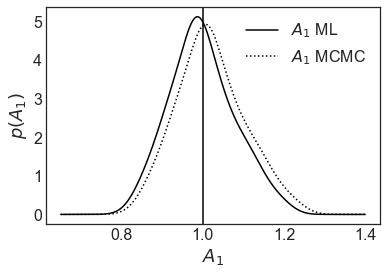

In [12]:
plt.figure(facecolor="white")
xs = np.linspace(0.65,1.4,200)
densityA1 = gaussian_kde(corr1k['A1'])
densitya1 = gaussian_kde(corr1k['a1'])
plt.plot(xs,densityA1(xs),"k-",label=r"$A_{1}$ ML")
plt.plot(xs,densitya1(xs),"k:",label=r"$A_{1}$ MCMC")
plt.axvline(x=1.0,color="k")
plt.legend()
plt.xlabel(r"$A_1$")
plt.ylabel(r"$p(A_{1})$")
plt.savefig("A1kde09.png",format="png",dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")

/opt/miniconda3/envs/pymc3/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "backgroundcolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  # This is added back by InteractiveShellApp.init_path()


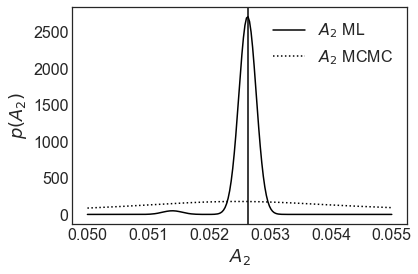

In [13]:
plt.figure(facecolor="white")
xs = np.linspace(0.05,0.055,200)
densityA2 = gaussian_kde(corr1k['A2'])
densitya2 = gaussian_kde(corr1k['a2'])
plt.plot(xs,densityA2(xs),"k-",label=r"$A_{2}$ ML")
plt.plot(xs,densitya2(xs),"k:",label=r"$A_{2}$ MCMC")
plt.axvline(x=1.0/19.0,color="k")
plt.legend()
plt.xlabel(r"$A_2$")
plt.ylabel(r"$p(A_{2})$")
plt.savefig("A2kde09.png",format="png",dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")

In [14]:
# display statistics
print(corr1k['dA1dA2'].mean(),corr1k['dA1dA2'].std(),corr1k['dA1dD'].mean(),corr1k['dA2dD'].mean())
print(corr1k['da1da2'].mean(),corr1k['dA1dA2'].std(),corr1k['da1dd'].mean(),corr1k['dasdd'].mean())

8.17229886094292e-08 4.206759264278311e-07 0.00172967249779522 1.0118592283491577e-07
3.6677878955239164e-07 4.206759264278311e-07 0.00017677959429380932 1.2258709754928154e-07


(array([ 2.,  0.,  2.,  1.,  3.,  4.,  4.,  4.,  4., 10.,  7.,  6.,  8.,
         6.,  5.,  3.,  3.,  3.,  6.,  1.,  4.,  2.,  6.,  1.,  0.,  0.,
         1.,  1.,  1.,  2.]),
 array([0.06671979, 0.06839018, 0.07006058, 0.07173098, 0.07340138,
        0.07507178, 0.07674218, 0.07841257, 0.08008297, 0.08175337,
        0.08342377, 0.08509417, 0.08676456, 0.08843496, 0.09010536,
        0.09177576, 0.09344616, 0.09511655, 0.09678695, 0.09845735,
        0.10012775, 0.10179815, 0.10346855, 0.10513894, 0.10680934,
        0.10847974, 0.11015014, 0.11182054, 0.11349093, 0.11516133,
        0.11683173]),
 <BarContainer object of 30 artists>)

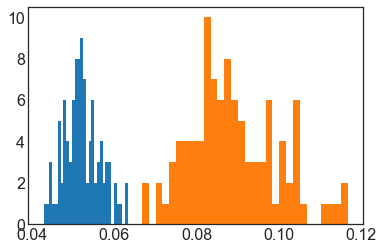

In [15]:
plt.hist(corr1k['dA1'],bins=30)
plt.hist(corr1k['da1'],bins=30)

(array([ 1.,  0.,  0.,  2.,  3.,  5.,  5.,  4.,  0., 15.,  7.,  9., 12.,
         8.,  4.,  5.,  3.,  6.,  3.,  2.,  0.,  1.,  0.,  1.,  1.,  1.,
         0.,  0.,  1.,  1.]),
 array([0.00214211, 0.00216341, 0.00218471, 0.00220601, 0.00222732,
        0.00224862, 0.00226992, 0.00229122, 0.00231252, 0.00233382,
        0.00235513, 0.00237643, 0.00239773, 0.00241903, 0.00244033,
        0.00246163, 0.00248293, 0.00250424, 0.00252554, 0.00254684,
        0.00256814, 0.00258944, 0.00261074, 0.00263204, 0.00265335,
        0.00267465, 0.00269595, 0.00271725, 0.00273855, 0.00275985,
        0.00278115]),
 <BarContainer object of 30 artists>)

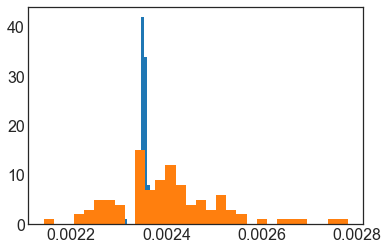

In [16]:
plt.hist(corr1k['dA2'],bins=30)
plt.hist(corr1k['da2'],bins=30)

In [17]:
print(corr1k['A1'].std()/corr1k['dA1'].mean())
print(corr1k['A2'].std()/corr1k['dA2'].mean())
print(corr1k['D'].std()/corr1k['dD'].mean())
print(corr1k['dA1dA2'].mean()/corr1k['da1da2'].mean())
print(corr1k['dA1dD'].mean()/corr1k['da1dd'].mean())
print(corr1k['dA2dD'].mean()/corr1k['dasdd'].mean())

1.500690402819403
0.15071877368086953
1.0878942387193542
0.22281274418611297
9.78434476391256
0.8254206589256897


(array([ 1.,  1.,  1.,  1.,  1.,  2.,  2.,  5.,  3.,  1.,  6., 13.,  4.,
         5.,  5., 11.,  8.,  5.,  5.,  6.,  4.,  1.,  1.,  4.,  2.,  0.,
         1.,  0.,  0.,  1.]),
 array([-3.22822514e-06, -2.97687623e-06, -2.72552732e-06, -2.47417842e-06,
        -2.22282951e-06, -1.97148060e-06, -1.72013169e-06, -1.46878278e-06,
        -1.21743388e-06, -9.66084969e-07, -7.14736061e-07, -4.63387153e-07,
        -2.12038245e-07,  3.93106626e-08,  2.90659570e-07,  5.42008478e-07,
         7.93357386e-07,  1.04470629e-06,  1.29605520e-06,  1.54740411e-06,
         1.79875302e-06,  2.05010193e-06,  2.30145083e-06,  2.55279974e-06,
         2.80414865e-06,  3.05549756e-06,  3.30684646e-06,  3.55819537e-06,
         3.80954428e-06,  4.06089319e-06,  4.31224210e-06]),
 <BarContainer object of 30 artists>)

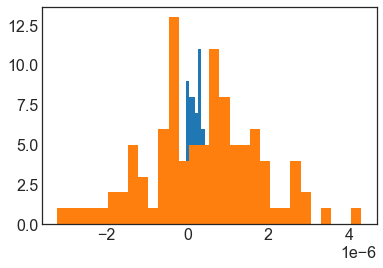

In [18]:
plt.hist(corr1k['dA1dA2'],bins=30)
plt.hist(corr1k['da1da2'],bins=30)

(array([ 3.,  1.,  0.,  4.,  4.,  1.,  2.,  6.,  9.,  5.,  5.,  7., 13.,
         5.,  8.,  7.,  5.,  4.,  4.,  1.,  1.,  0.,  2.,  1.,  0.,  0.,
         0.,  0.,  1.,  1.]),
 array([9.17197780e-05, 9.88048891e-05, 1.05890000e-04, 1.12975111e-04,
        1.20060222e-04, 1.27145334e-04, 1.34230445e-04, 1.41315556e-04,
        1.48400667e-04, 1.55485778e-04, 1.62570889e-04, 1.69656000e-04,
        1.76741111e-04, 1.83826222e-04, 1.90911334e-04, 1.97996445e-04,
        2.05081556e-04, 2.12166667e-04, 2.19251778e-04, 2.26336889e-04,
        2.33422000e-04, 2.40507111e-04, 2.47592222e-04, 2.54677334e-04,
        2.61762445e-04, 2.68847556e-04, 2.75932667e-04, 2.83017778e-04,
        2.90102889e-04, 2.97188000e-04, 3.04273111e-04]),
 <BarContainer object of 30 artists>)

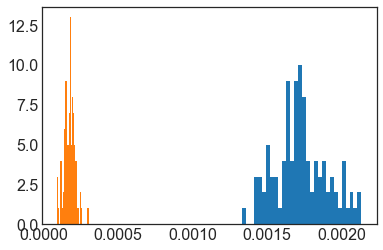

In [19]:
plt.hist(corr1k['dA1dD'],bins=30)
plt.hist(corr1k['da1dd'],bins=30)

(array([ 1.,  0.,  0.,  2.,  1.,  2.,  4.,  3.,  4.,  5.,  1.,  6.,  7.,
        10.,  4.,  6.,  8.,  5.,  4.,  4.,  3.,  7.,  4.,  2.,  2.,  0.,
         2.,  1.,  1.,  1.]),
 array([-2.43861829e-06, -2.26939020e-06, -2.10016212e-06, -1.93093403e-06,
        -1.76170595e-06, -1.59247787e-06, -1.42324978e-06, -1.25402170e-06,
        -1.08479361e-06, -9.15565530e-07, -7.46337446e-07, -5.77109362e-07,
        -4.07881278e-07, -2.38653194e-07, -6.94251097e-08,  9.98029744e-08,
         2.69031058e-07,  4.38259143e-07,  6.07487227e-07,  7.76715311e-07,
         9.45943395e-07,  1.11517148e-06,  1.28439956e-06,  1.45362765e-06,
         1.62285573e-06,  1.79208382e-06,  1.96131190e-06,  2.13053998e-06,
         2.29976807e-06,  2.46899615e-06,  2.63822424e-06]),
 <BarContainer object of 30 artists>)

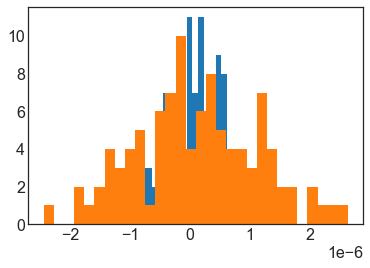

In [20]:
plt.hist(corr1k['dA2dD'],bins=30)
plt.hist(corr1k['dasdd'],bins=30)

[0.39901218 0.01667193]
factor of underestimation:  2.506189162447747


/opt/miniconda3/envs/pymc3/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "backgroundcolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  # This is added back by InteractiveShellApp.init_path()


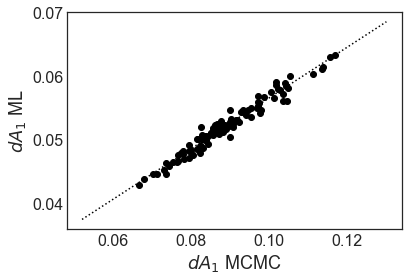

In [21]:
p1 = np.polyfit(corr1k['da1'],corr1k['dA1'],1)
print(p1)
print("factor of underestimation: ",1/p1[0])
da1 = np.linspace(0.052,0.13,200)
dA1 = p1[0]*da1 + p1[1]
plt.figure(facecolor="white")
plt.scatter(corr1k['da1'],corr1k['dA1'],color="k")
plt.plot(da1,dA1,"k:")
plt.xlabel(r"$dA_1$ MCMC")
plt.ylabel(r"$dA_{1}$ ML")
plt.savefig("dA1corrkde09.png",format="png",dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")

[0.02390677 0.00229559]
factor of underestimation:  41.829161013788315


/opt/miniconda3/envs/pymc3/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "backgroundcolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  del sys.path[0]


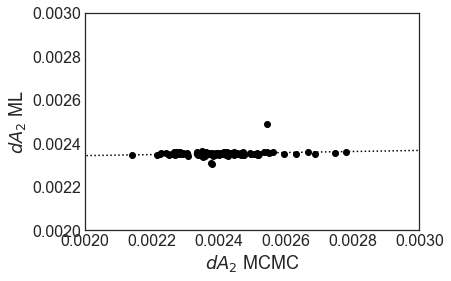

In [22]:
p1 = np.polyfit(corr1k['da2'],corr1k['dA2'],1)
print(p1)
print("factor of underestimation: ",1/p1[0])
da2 = np.linspace(0.00,0.005,200)
dA2 = p1[0]*da2 + p1[1]
plt.figure(facecolor="white")
plt.scatter(corr1k['da2'],corr1k['dA2'],color="k")
plt.plot(da2,dA2,"k:")
plt.xlabel(r"$dA_2$ MCMC")
plt.ylabel(r"$dA_{2}$ ML")
plt.xlim((0.002,0.003))
plt.ylim((0.002,0.003))
plt.savefig("dA2corrkde09.png",format="png",dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")

In [23]:
corr1k['dA2'].min()

0.0023039386846017865